# Module 2: PSF Generation with Aberrations

## Tutorials

### Beginner: making a broadband telescope PSF

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from hcipy import *

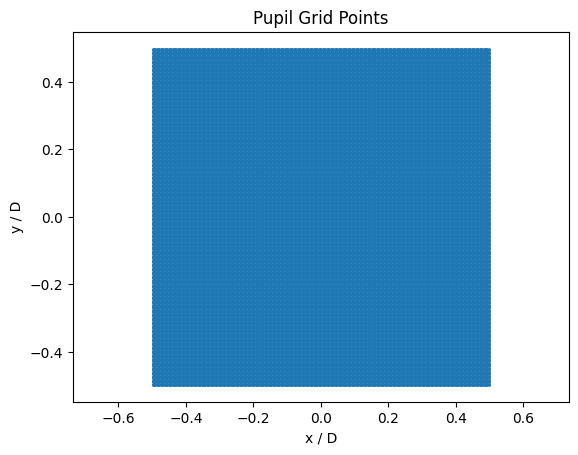

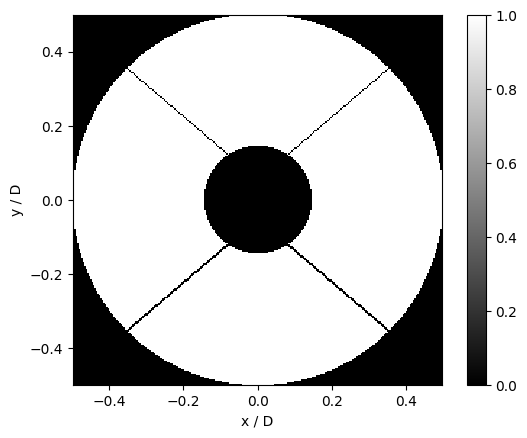

In [3]:
pupil_grid = make_pupil_grid(256)

# Plot the pupil grid points
plt.figure()
plt.scatter(pupil_grid.x, pupil_grid.y, s=1)
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.title('Pupil Grid Points')
plt.axis('equal')
plt.show()

telescope_pupil_generator = make_magellan_aperture(normalized=True)

telescope_pupil = telescope_pupil_generator(pupil_grid)

im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

Now that we have a pupil for our telescope, we can start creating the PSF

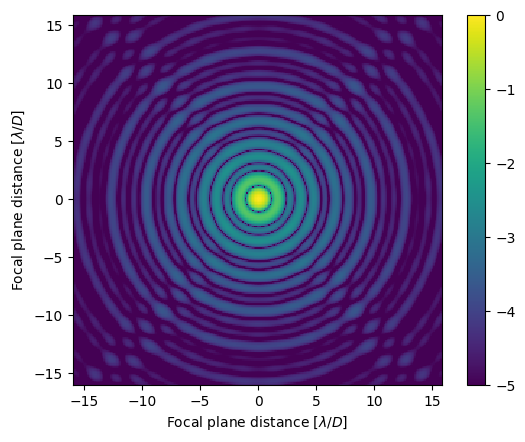

In [4]:
wavefront = Wavefront(telescope_pupil)

focal_grid = make_focal_grid(q=8, num_airy=16)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

focal_image = prop.forward(wavefront)

imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

Next, take a slice across the image to see how the flux changes as a function of angular separation

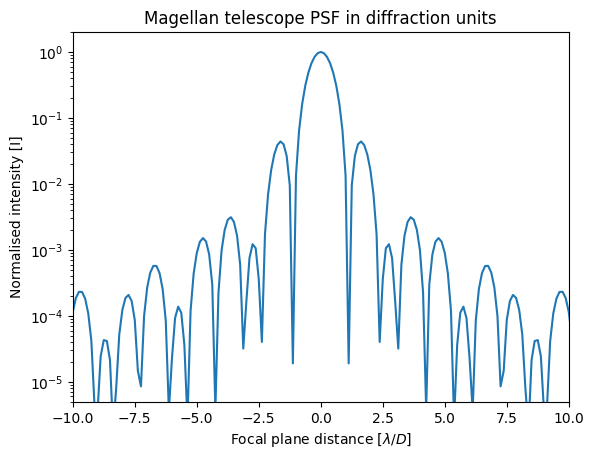

In [5]:
psf = focal_image.intensity
psf_shape = psf.grid.shape

slicefoc = psf.shaped[:, psf_shape[0] // 2]
slicefoc_normalised = slicefoc / psf.max()

plt.plot(focal_grid.x.reshape(psf_shape)[0, :], slicefoc_normalised)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Normalised intensity [I]')
plt.yscale('log')
plt.title('Magellan telescope PSF in diffraction units')
plt.xlim(-10, 10)
plt.ylim(5e-6, 2)
plt.show()

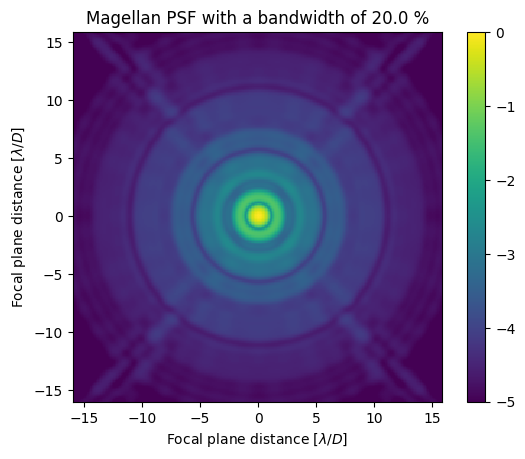

In [6]:
bandwidth = 0.2

focal_total = 0
for wlen in np.linspace(1 - bandwidth / 2., 1 + bandwidth / 2., 11):
    wavefront = Wavefront(telescope_pupil, wlen)
    focal_total += prop(wavefront).intensity

imshow_field(np.log10(focal_total / focal_total.max()), vmin=-5)

plt.title('Magellan PSF with a bandwidth of {:.1f} %'.format(bandwidth * 100))
plt.colorbar()
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.show()


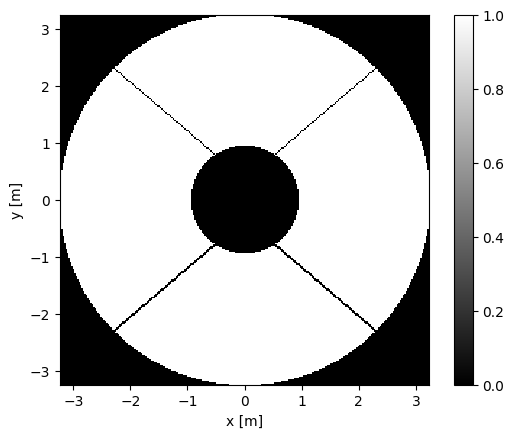

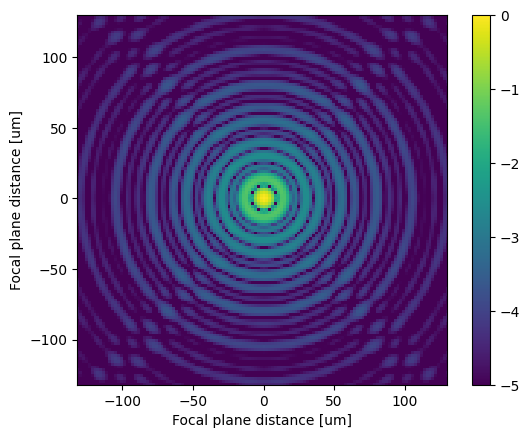

In [7]:
pupil_diameter = 6.5 # m
effective_focal_length = 71.5 # m
wavelength = 750e-9 # m

pupil_grid = make_pupil_grid(256, diameter=pupil_diameter)

telescope_pupil_generator = make_magellan_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

wavefront = Wavefront(telescope_pupil, wavelength)

focal_grid = make_focal_grid(q=4, num_airy=16, pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)

focal_image = prop.forward(wavefront)

imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

### Beginner: Near and Far Field Diffraction
I won't have to do near field diffraction, just far.

/var/folders/vt/0z4j3ykd0jb4gq988cy7qqv80000gn/T/ipykernel_2013/4180793406.py:22: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  aperture_circ = evaluate_supersampled(circular_aperture(pupil_diameter), pupil_grid, 8)


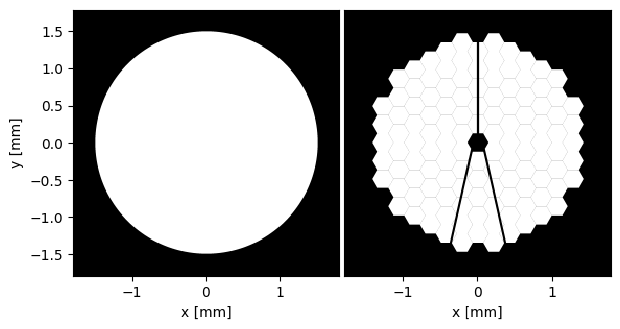

In [8]:
def double_plot(a, b, title='', xlabel='', ylabel='', **kwargs):
    '''A function to nicely show two fields side-to-side.
    '''
    fig, axes = plt.subplots(1, 2, gridspec_kw={'left': 0.14, 'right': 0.98, 'top': 0.95, 'bottom': 0.07, 'wspace': 0.02})
    fig.suptitle(title)

    imshow_field(a, **kwargs, ax=axes[0])
    imshow_field(b, **kwargs, ax=axes[1])

    axes[1].yaxis.set_ticks([])
    axes[0].set_xlabel(xlabel)
    axes[1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    return fig


pupil_diameter = 3e-3 # meter
wavelength = 500e-9 # meter

pupil_grid = make_pupil_grid(256, 1.2 * pupil_diameter)
aperture_circ = evaluate_supersampled(circular_aperture(pupil_diameter), pupil_grid, 8)

aperture_luvoir = evaluate_supersampled(make_luvoir_a_aperture(True), pupil_grid.scaled(1 / pupil_diameter), 8)
aperture_luvoir.grid = pupil_grid

wf_circ = Wavefront(aperture_circ, wavelength)
wf_luvoir = Wavefront(aperture_luvoir, wavelength)

double_plot(aperture_circ, aperture_luvoir,
            xlabel='x [mm]', ylabel='y [mm]',
            grid_units=1e-3, cmap='gray')
plt.show()

Now that we have the pupil, we need to do far field diffraction with the Fraunhofer approximation.

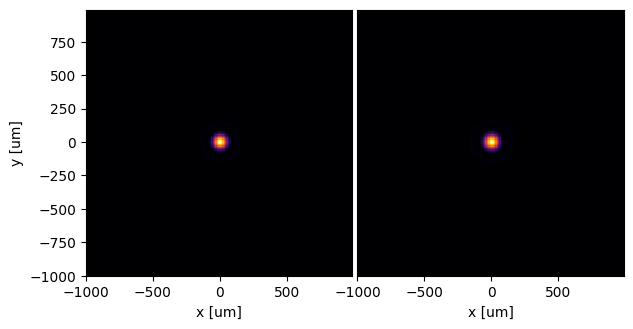

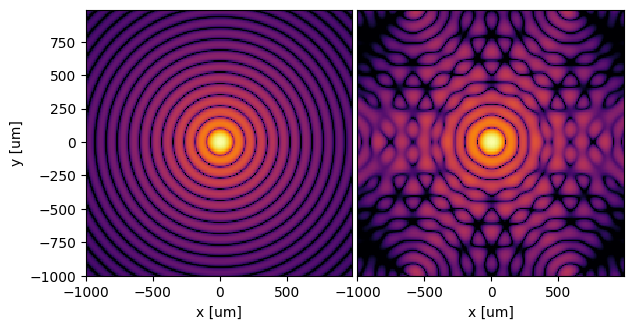

In [9]:
focal_length = 0.5 # meter

spatial_resolution = focal_length / pupil_diameter * wavelength
focal_grid = make_focal_grid(8, 12, spatial_resolution=spatial_resolution)
fraunhofer = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=focal_length)

img_circ = fraunhofer(wf_circ)
img_luvoir = fraunhofer(wf_luvoir)

double_plot(img_circ.power, img_luvoir.power,
            xlabel='x [um]', ylabel='y [um]',
            cmap='inferno', grid_units=1e-6)
plt.show()

double_plot(np.log10(img_circ.power / img_circ.power.max()), np.log10(img_luvoir.power / img_luvoir.power.max()),
            xlabel='x [um]', ylabel='y [um]',
            vmin=-6, cmap='inferno', grid_units=1e-6)
plt.show()

Wavelengths can be passed to the propogators too

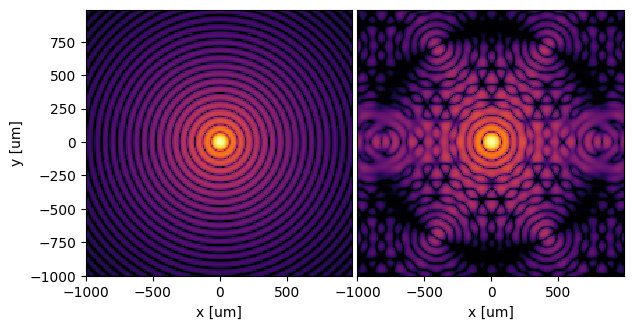

In [10]:
wf_circ.wavelength = 350e-9 # meter
wf_luvoir.wavelength = 350e-9 # meter

img_circ = fraunhofer(wf_circ)
img_luvoir = fraunhofer(wf_luvoir)

double_plot(np.log10(img_circ.power / img_circ.power.max()), np.log10(img_luvoir.power / img_luvoir.power.max()),
            xlabel='x [um]', ylabel='y [um]',
            vmin=-6, cmap='inferno', grid_units=1e-6)
plt.show()

### Beginner: Telescope pupils and grids

In [11]:
vlt_aperture = make_vlt_aperture()

print(type(vlt_aperture))

<class 'function'>


In [12]:
grid = make_pupil_grid(128, diameter=10)

print(type(grid))
print(type(grid.coords))

<class 'hcipy.field.cartesian_grid.CartesianGrid'>
<class 'hcipy.field.coordinates.RegularCoords'>


x: [-4.9609375 -4.8828125 -4.8046875 ...  4.8046875  4.8828125  4.9609375]
y: [-4.9609375 -4.9609375 -4.9609375 ...  4.9609375  4.9609375  4.9609375]
x[100]: 2.8515625
y[100]: -4.9609375
(x, y): [ 2.8515625 -4.9609375]


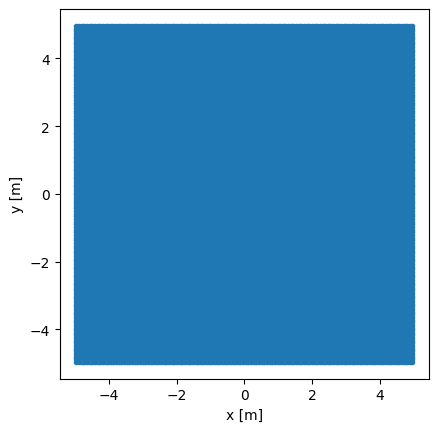

In [15]:
print('x:', grid.x)
print('y:', grid.y)
print('x[100]:', grid.x[100])
print('y[100]:', grid.y[100])
print('(x, y):', grid.points[100])

plt.plot(grid.x, grid.y, '.')
plt.gca().set_aspect(1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

Lets zoom in

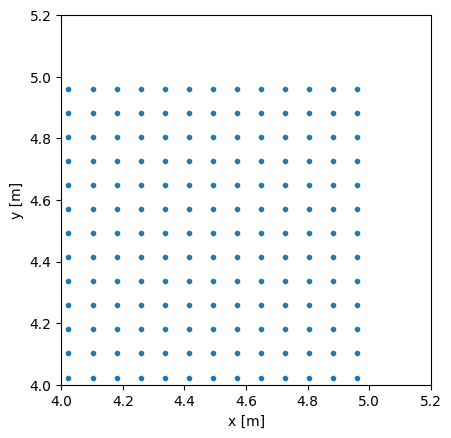

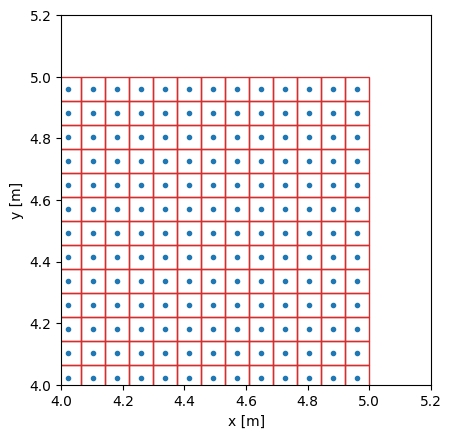

In [18]:
plt.plot(grid.x, grid.y, '.')
plt.gca().set_aspect(1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(4, 5.2)
plt.ylim(4, 5.2)
plt.show()

plt.plot(grid.x, grid.y, '.')
plt.gca().set_aspect(1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(4, 5.2)
plt.ylim(4, 5.2)

for p in grid.points:
    rect = plt.Rectangle(p - grid.delta / 2, *grid.delta, linewidth=1, edgecolor=colors.red, facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

<class 'hcipy.field.field.OldStyleField'>
The grid of aperture: CartesianGrid(RegularCoords)


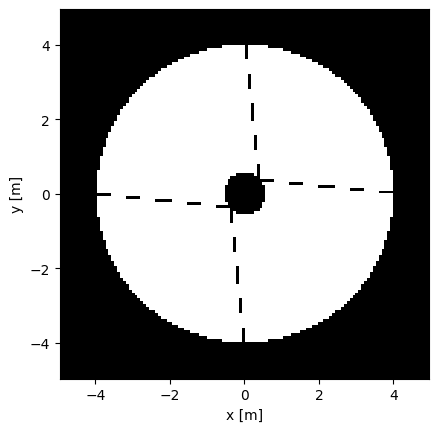

In [23]:
aperture = vlt_aperture(grid)

print(type(aperture))
print('The grid of aperture:', aperture.grid)
imshow_field(aperture, cmap='gray', interpolation='nearest')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

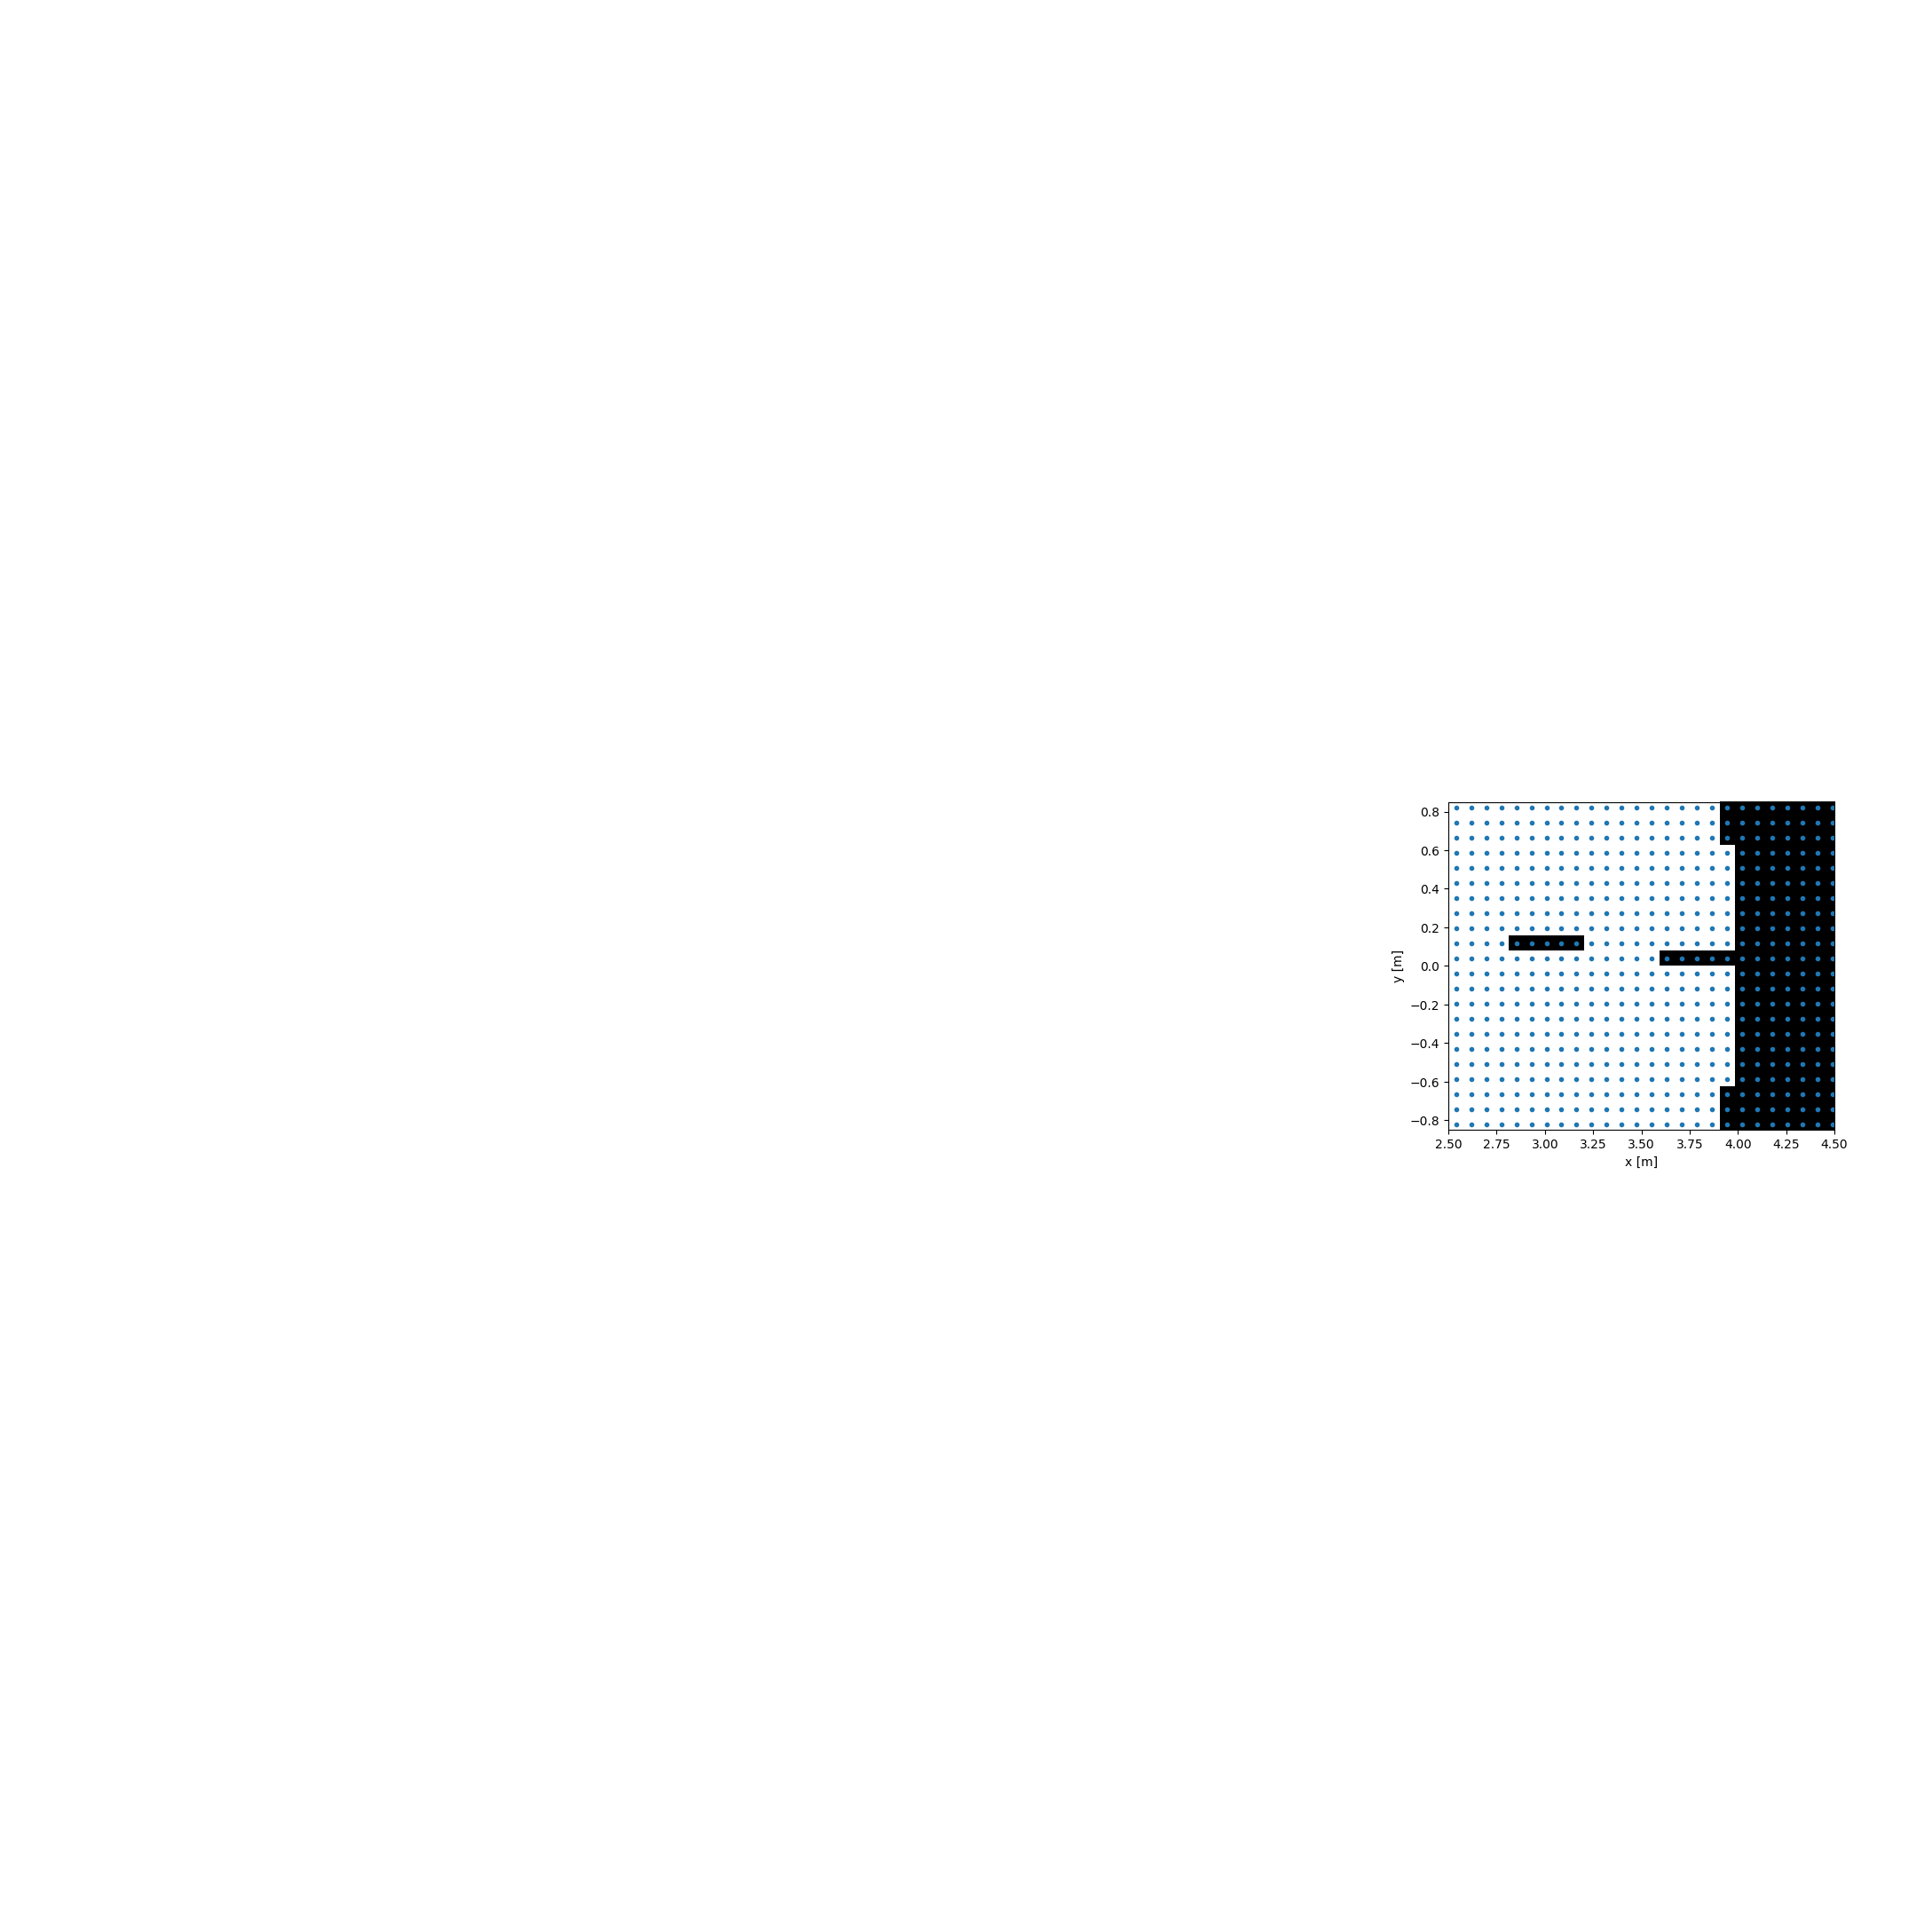

In [24]:
imshow_field(aperture, cmap='gray', interpolation='nearest')
plt.plot(grid.x, grid.y, '.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(2.5, 4.5)
plt.ylim(-0.85, 0.85)
plt.show()

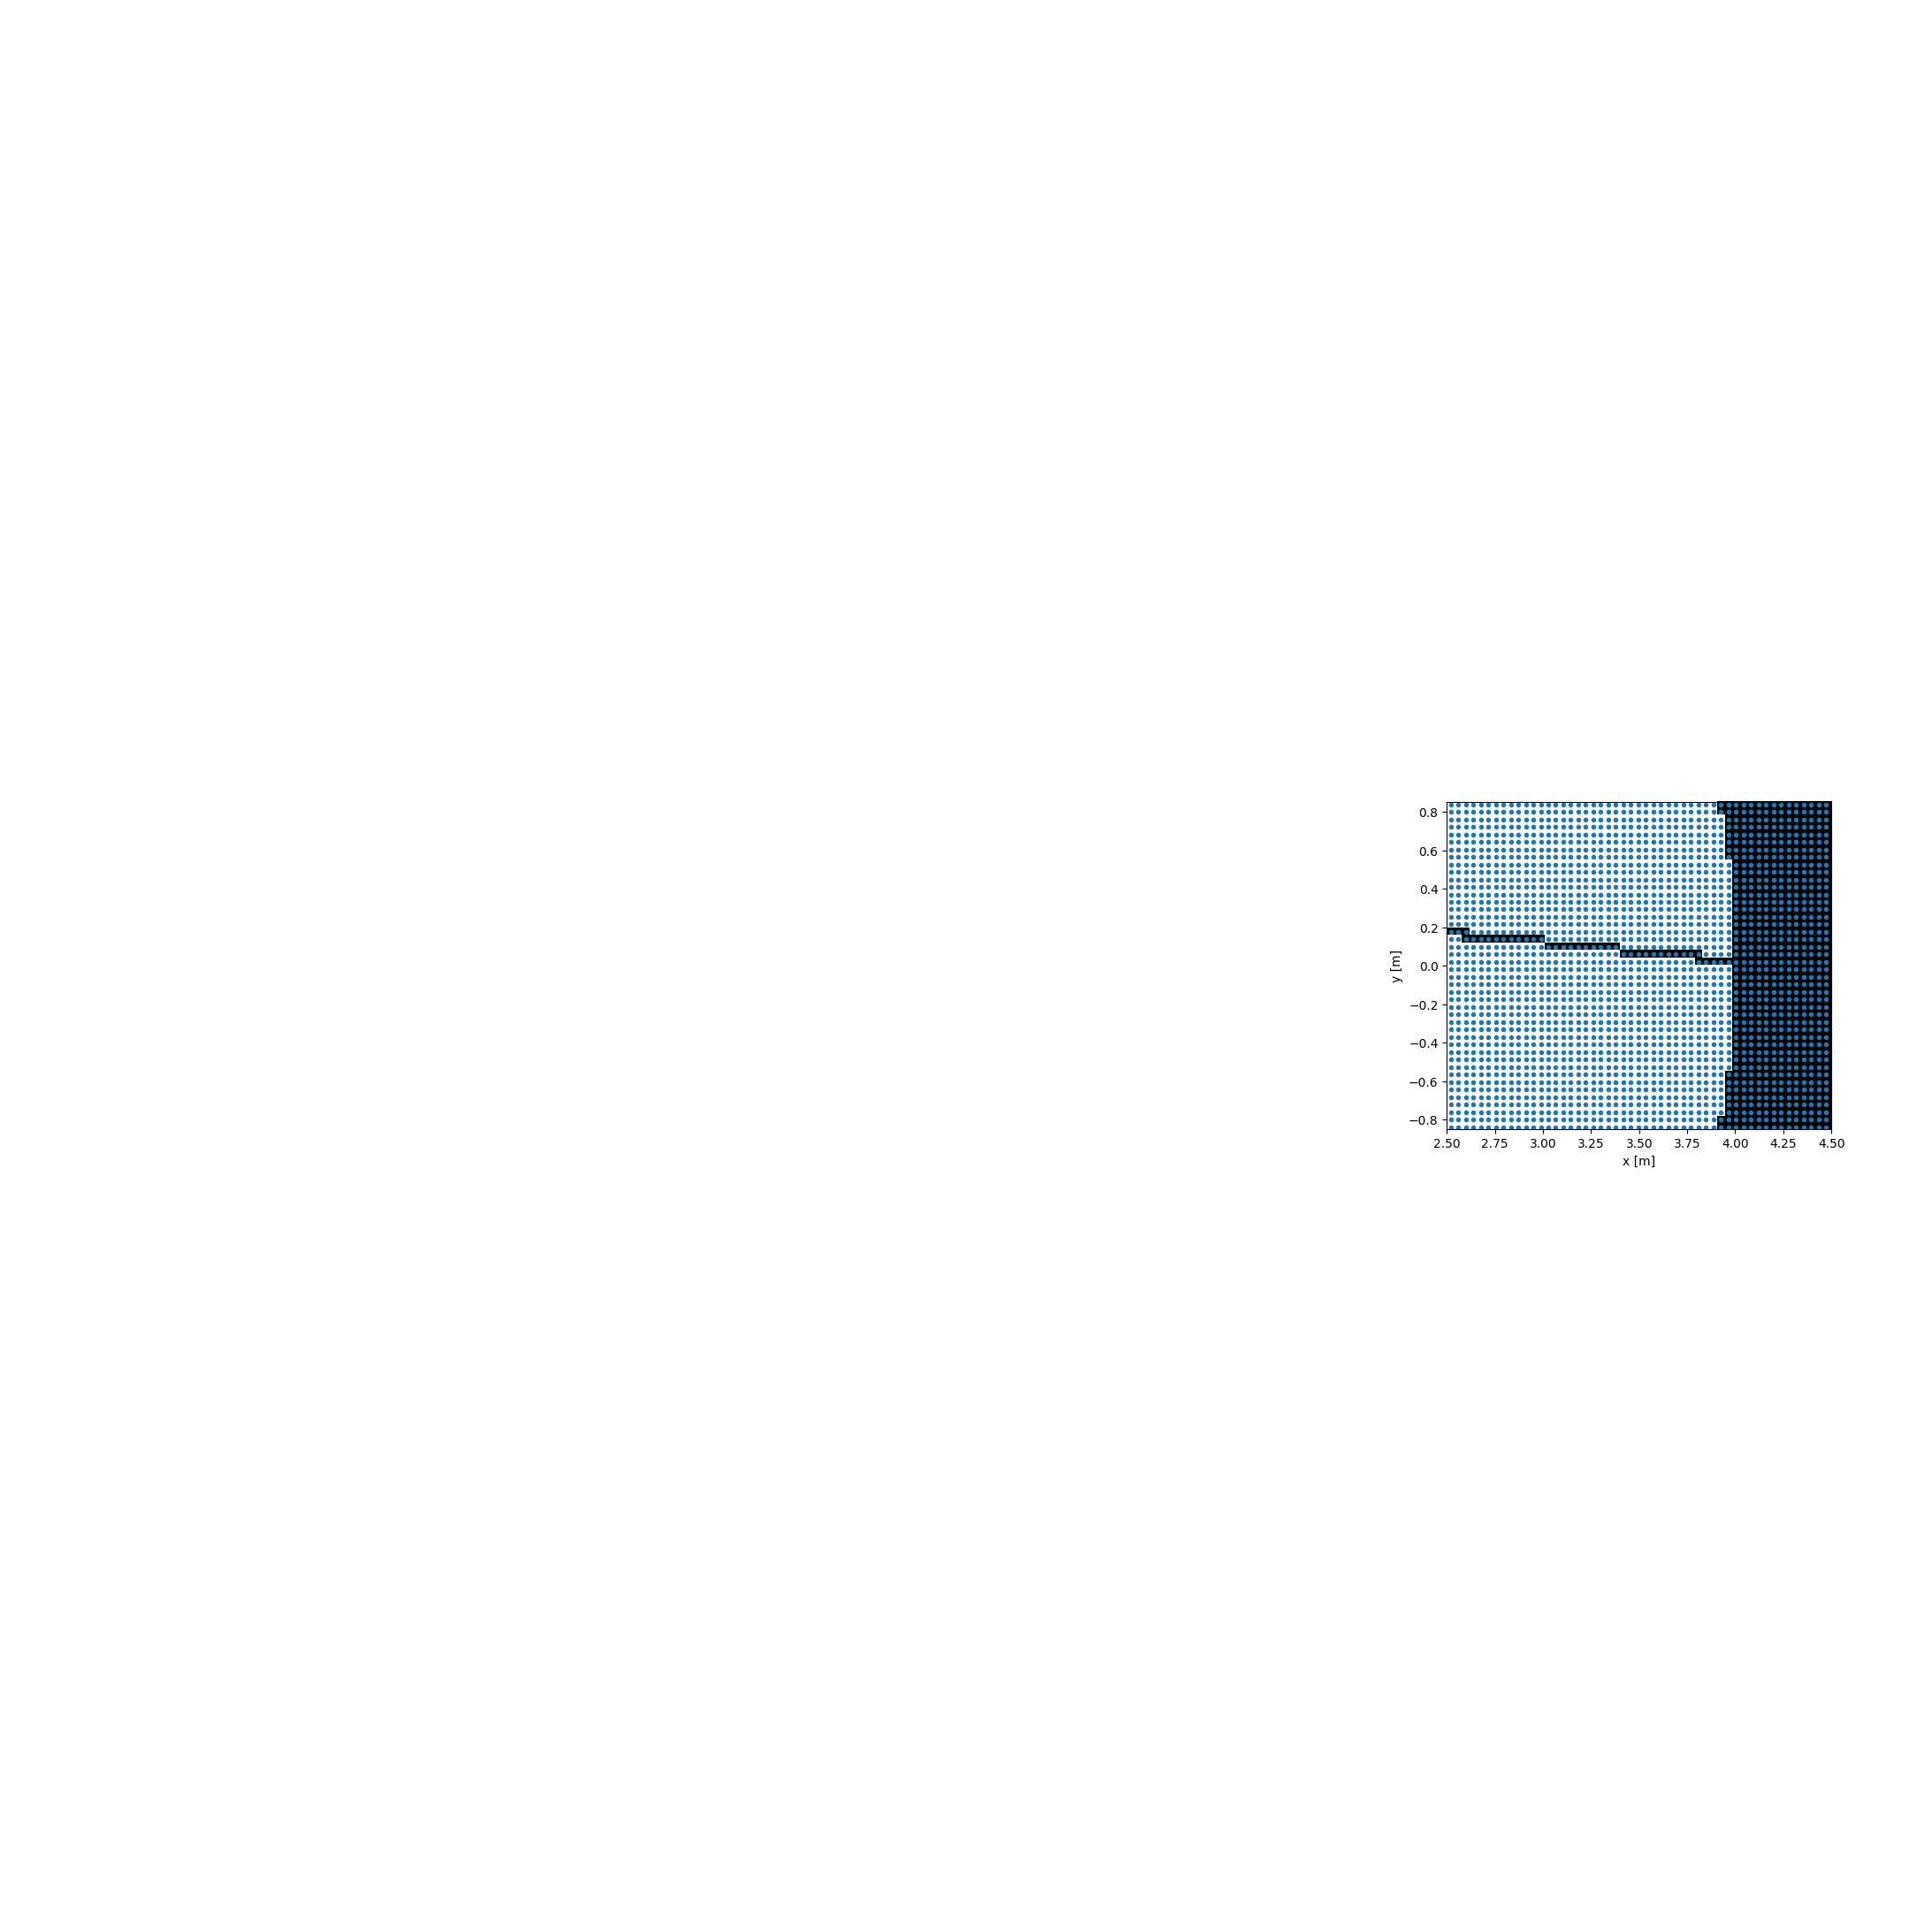

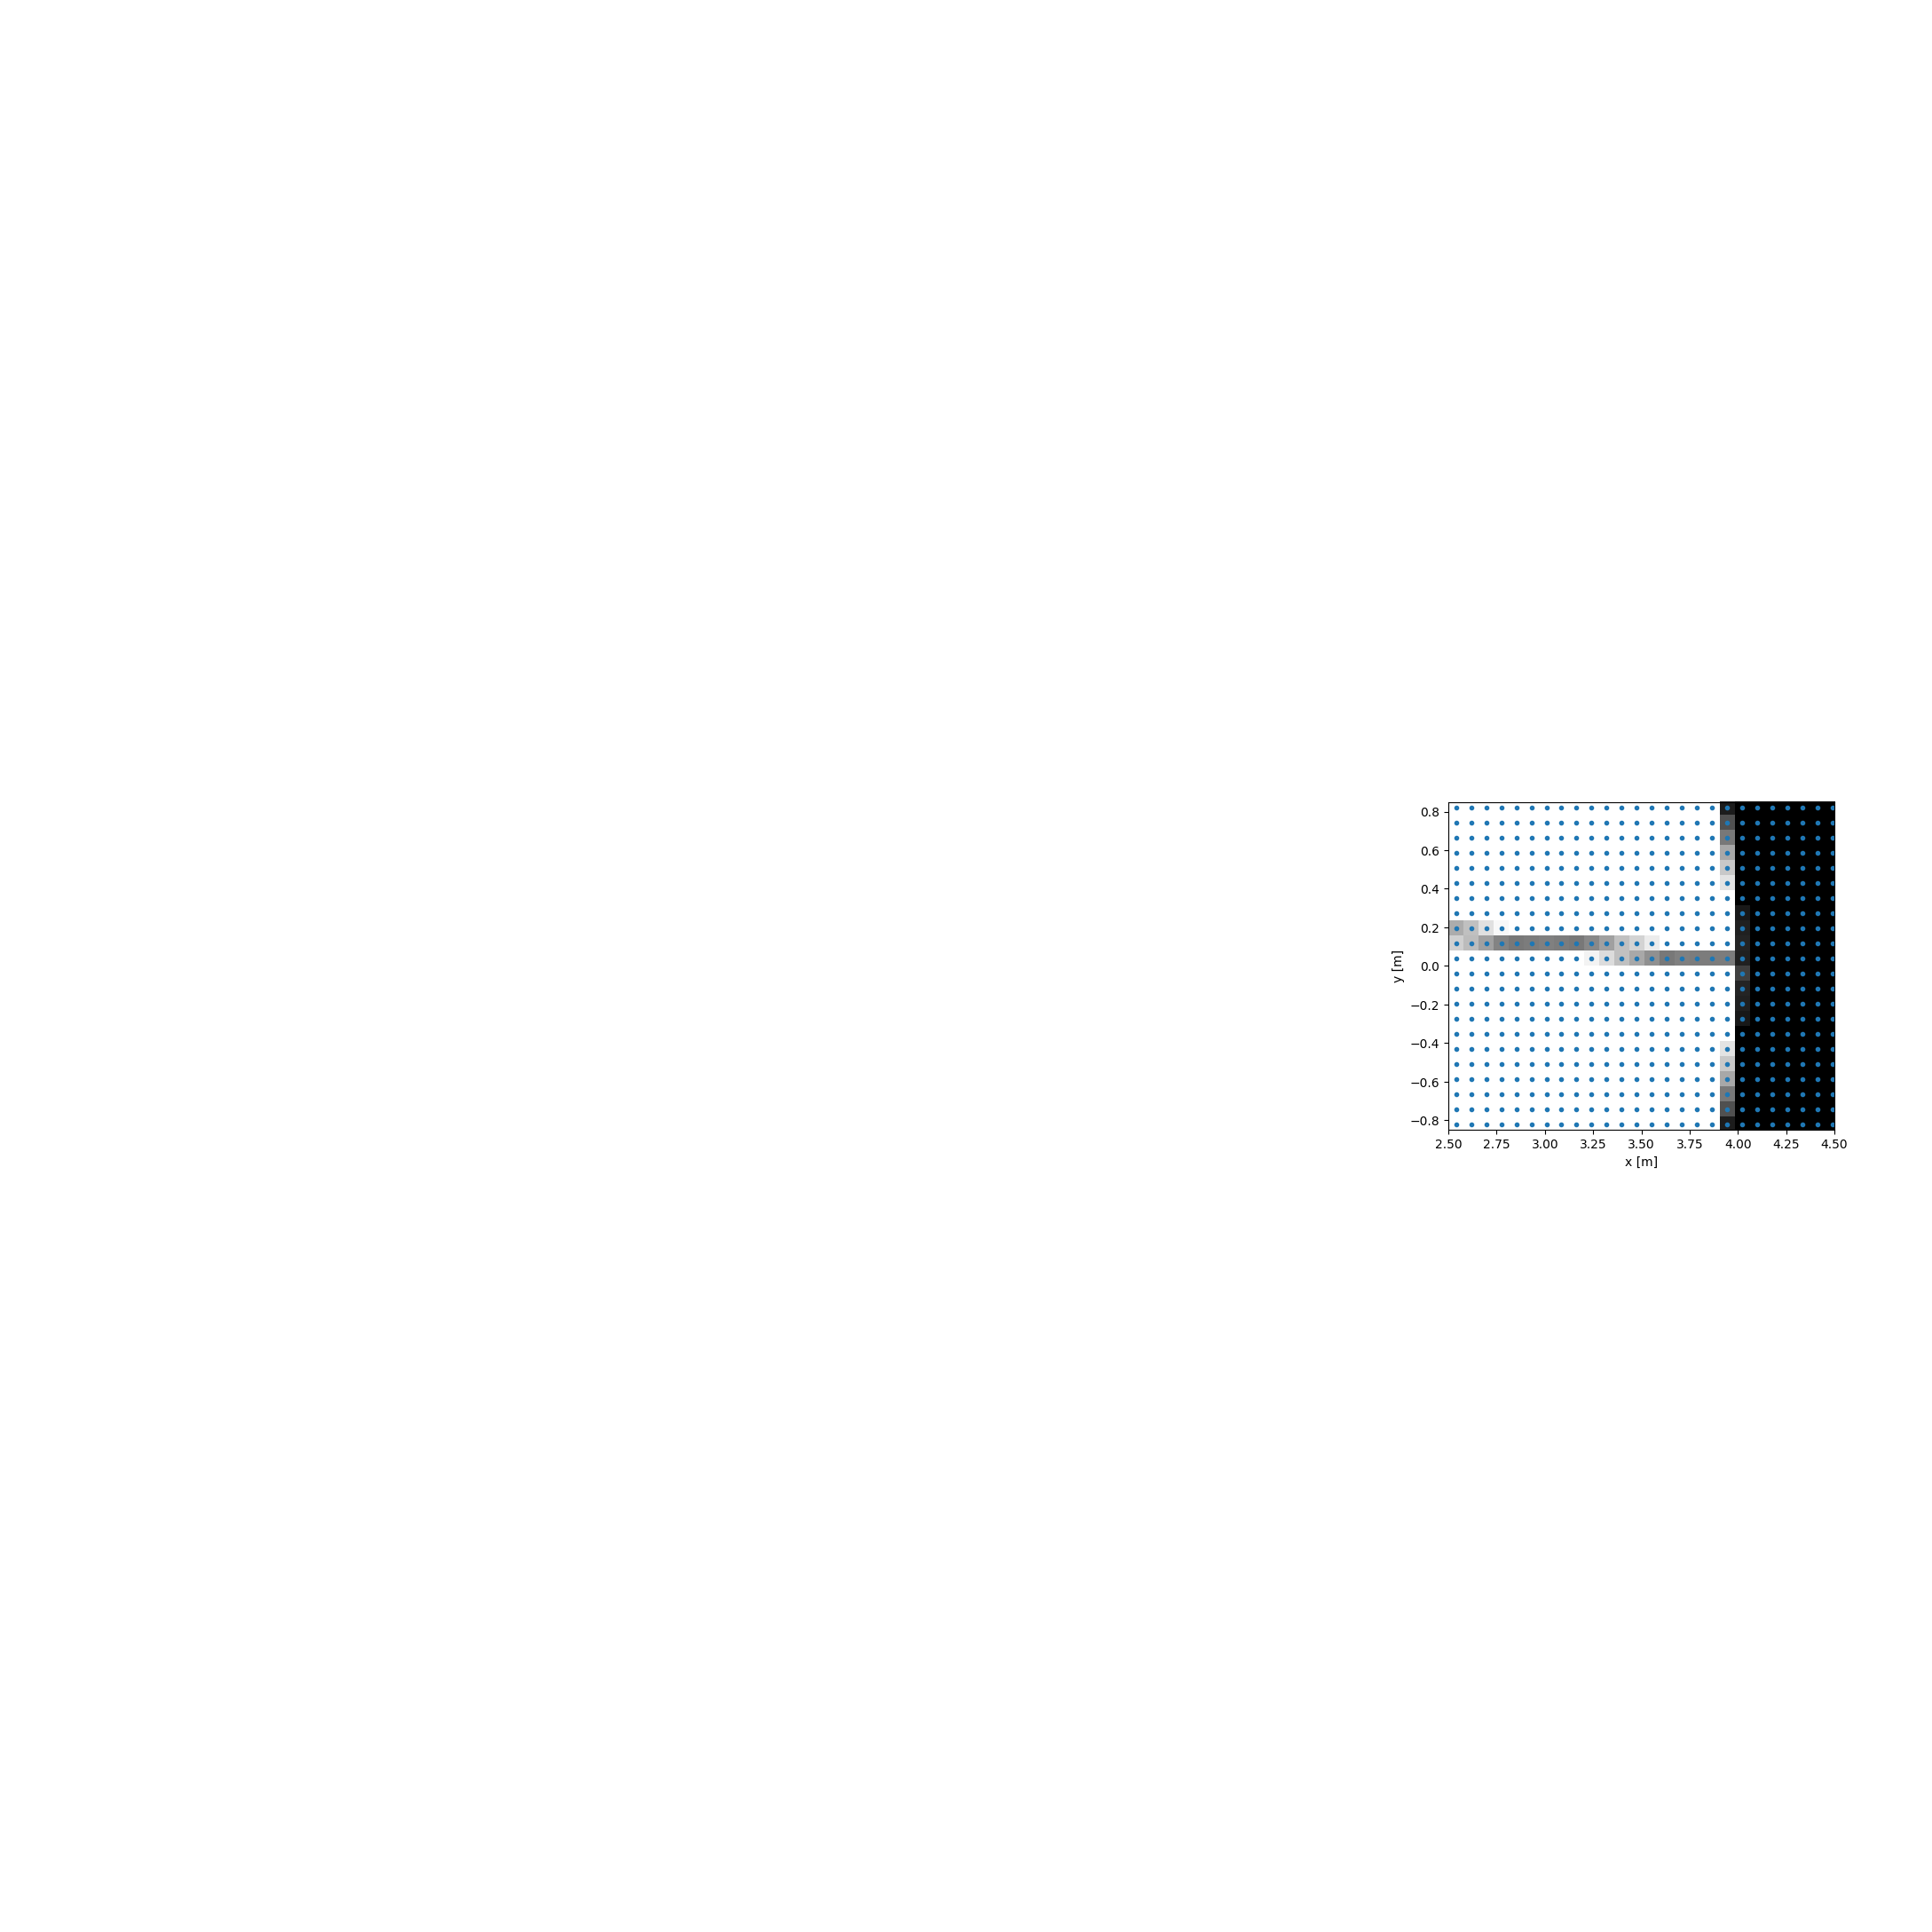

In [44]:
grid_double = make_supersampled_grid(grid, 2)
aperture_double = vlt_aperture(grid_double)

imshow_field(aperture_double, cmap='gray', interpolation='nearest')
plt.plot(grid_double.x, grid_double.y, '.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(2.5, 4.5)
plt.ylim(-0.85, 0.85)
plt.show()

aperture_supersampled = evaluate_supersampled(vlt_aperture, grid, 8)

imshow_field(aperture_supersampled, cmap='gray', interpolation='nearest')
plt.plot(grid.x, grid.y, '.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(2.5, 4.5)
plt.ylim(-0.85, 0.85)
plt.show()

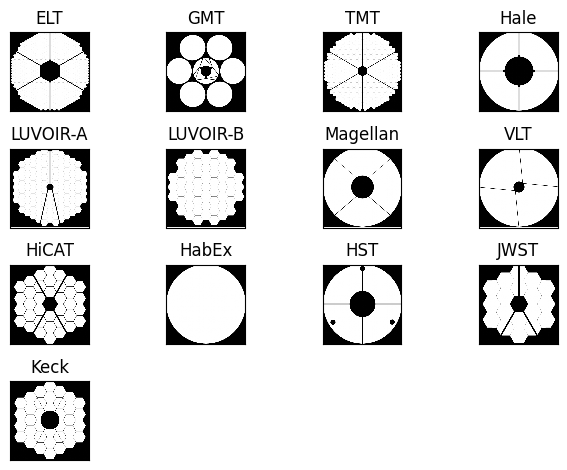

In [28]:
aperture_funcs = [
    ('ELT', make_elt_aperture),
    ('GMT', make_gmt_aperture),
    ('TMT', make_tmt_aperture),
    ('Hale', make_hale_aperture),
    ('LUVOIR-A', make_luvoir_a_aperture),
    ('LUVOIR-B', make_luvoir_b_aperture),
    ('Magellan', make_magellan_aperture),
    ('VLT', make_vlt_aperture),
    ('HiCAT', make_hicat_aperture),
    ('HabEx', make_habex_aperture),
    ('HST', make_hst_aperture),
    ('JWST', make_jwst_aperture),
    ('Keck', make_keck_aperture),
]

pupil_grid = make_pupil_grid(512)

n_width = 4
n_height = 4

for i, (label, aperture) in enumerate(aperture_funcs):
    img = evaluate_supersampled(aperture(normalized=True), pupil_grid, 4)

    ax = plt.subplot(n_height, n_width, i + 1)
    ax.set_title(label)
    imshow_field(img, cmap='gray', interpolation='bilinear', ax=ax)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

plt.tight_layout()
plt.show()


### Intermediate: Segmented deformable mirrors

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import hcipy

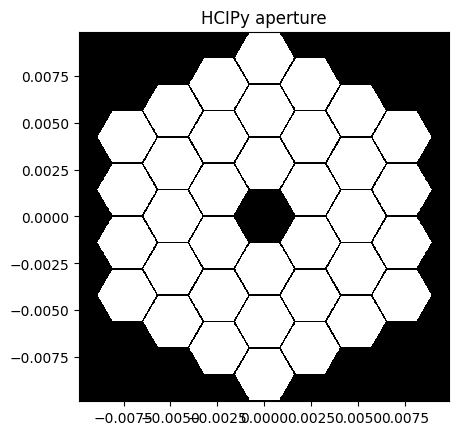

In [31]:
# Parameters for the pupil function
pupil_diameter = 0.019725 # m
gap_size = 90e-6 # m
num_rings = 3
segment_flat_to_flat = (pupil_diameter - (2 * num_rings + 1) * gap_size) / (2 * num_rings + 1)
focal_length = 1 # m

# Parameters for the simulation
num_pix = 1024
wavelength = 638e-9
num_airy = 20
sampling = 4
norm = False

# HCIPy grids and propagator
pupil_grid = hcipy.make_pupil_grid(dims=num_pix, diameter=pupil_diameter)

focal_grid = hcipy.make_focal_grid(sampling, num_airy,
                                   pupil_diameter=pupil_diameter,
                                   reference_wavelength=wavelength,
                                   focal_length=focal_length)
focal_grid = focal_grid.shifted(focal_grid.delta / 2)

prop = hcipy.FraunhoferPropagator(pupil_grid, focal_grid, focal_length)

aper, segments = hcipy.make_hexagonal_segmented_aperture(num_rings,
                                                         segment_flat_to_flat,
                                                         gap_size,
                                                         starting_ring=1,
                                                         return_segments=True)

aper = hcipy.evaluate_supersampled(aper, pupil_grid, 1)
segments = hcipy.evaluate_supersampled(segments, pupil_grid, 1)

plt.title('HCIPy aperture')
hcipy.imshow_field(aper, cmap='gray')

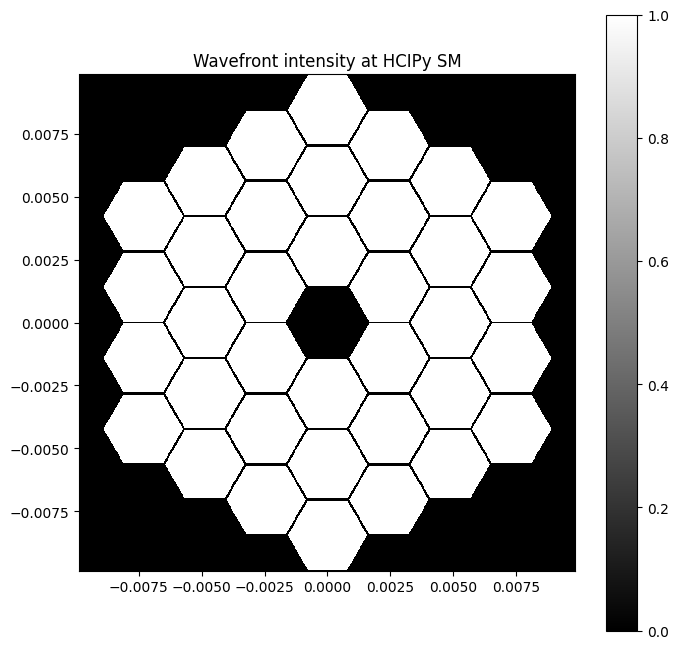

In [32]:
# Instantiate the segmented mirror
hsm = hcipy.SegmentedDeformableMirror(segments)

# Make a pupil plane wavefront from aperture
wf = hcipy.Wavefront(aper, wavelength)

# Apply SM if you want to
wf = hsm(wf)

plt.figure(figsize=(8, 8))
plt.title('Wavefront intensity at HCIPy SM')
hcipy.imshow_field(wf.intensity, cmap='gray')
plt.colorbar()
plt.show()

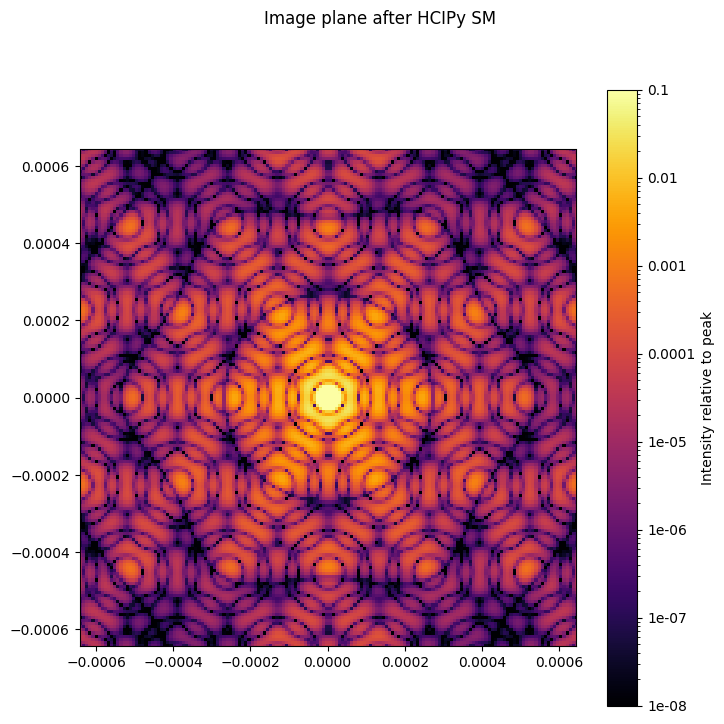

In [34]:
# Apply SM to pupil plane wf
wf_sm = hsm(wf)

# Propagate from SM to image plane
im_ref_hc = prop(wf_sm)

# Display intensity and phase in image plane
plt.figure(figsize=(8, 8))
plt.suptitle('Image plane after HCIPy SM')

# Get normalization factor for HCIPy reference image
norm_hc = np.max(im_ref_hc.intensity)

hcipy.imshow_psf(im_ref_hc, normalization='peak')

Aberration: 4.0 rad
Aberration: 4.061634147705169e-07 m


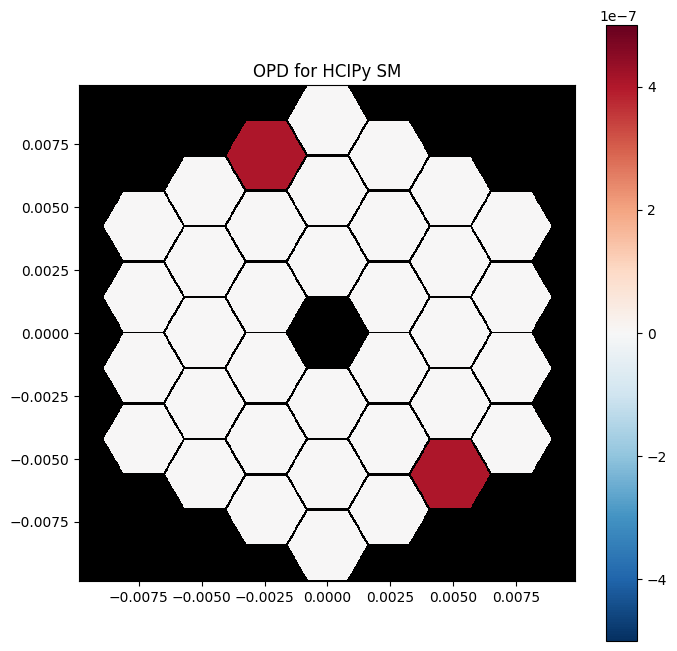

In [39]:
# Define function from rad of phase to m OPD
def aber_to_opd(aber_rad, wavelength):
    aber_m = aber_rad * wavelength / (2 * np.pi)
    return aber_m

aber_rad = 4.0

print('Aberration: {} rad'.format(aber_rad))
print('Aberration: {} m'.format(aber_to_opd(aber_rad, wavelength)))

# Poppy and HCIPy have a different way of indexing segments
# Figure out which index to poke on which mirror
poppy_index_to_hcipy_index = []
for n in range(1, num_rings + 1):
    base = list(range(3 * (n - 1) * n + 1, 3 * n * (n + 1) + 1))

    poppy_index_to_hcipy_index.extend(base[2 * n::-1])
    poppy_index_to_hcipy_index.extend(base[:2 * n:-1])

poppy_index_to_hcipy_index = {j: i for i, j in enumerate(poppy_index_to_hcipy_index) if j is not None}

hcipy_index_to_poppy_index = {j: i for i, j in poppy_index_to_hcipy_index.items()}

# Flatten both SMs just to be sure
hsm.flatten()

# Poking segment 35 and 25
for i in [35, 25]:
    hsm.set_segment_actuators(i, aber_to_opd(aber_rad, wavelength) / 2, 0, 0)

# Display both segmented mirrors in OPD

# HCIPy
plt.figure(figsize=(8,8))
plt.title('OPD for HCIPy SM')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()
plt.show()

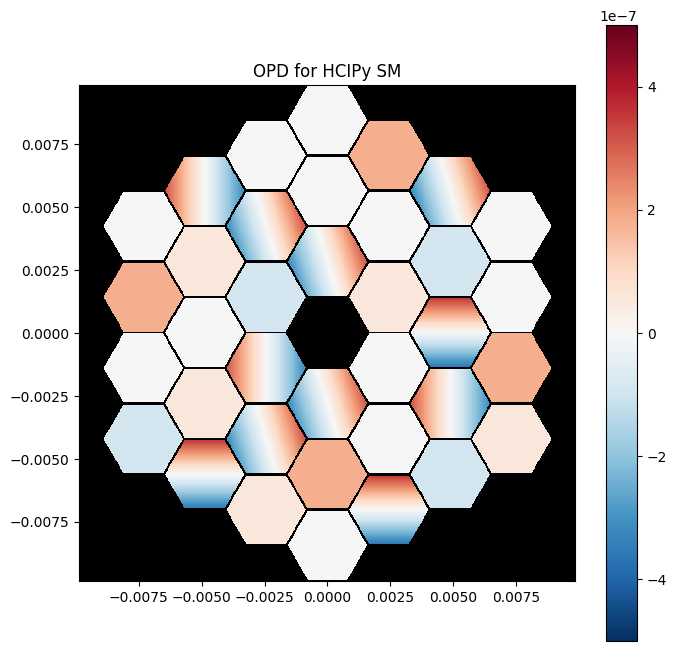

In [40]:
aber_rad_tt = 200e-6
aber_rad_p = 1.8

opd_piston = aber_to_opd(aber_rad_p, wavelength)

### Put aberrations on SM
# Flatten SM
hsm.flatten()

## PISTON
for i in [19, 28, 23, 16]:
    hsm.set_segment_actuators(i, opd_piston / 2, 0, 0)

for i in [3, 35, 30, 8]:
    hsm.set_segment_actuators(i, -0.5 * opd_piston / 2, 0, 0)

for i in [14, 18, 1, 32, 12]:
    hsm.set_segment_actuators(i, 0.3 * opd_piston / 2, 0, 0)

## TIP and TILT
for i in [2, 5, 11, 15, 22]:
    hsm.set_segment_actuators(i, 0, aber_rad_tt / 2, 0.3 * aber_rad_tt / 2)

for i in [4, 6, 26]:
    hsm.set_segment_actuators(i, 0, -aber_rad_tt / 2, 0)

for i in [34, 31, 7]:
    hsm.set_segment_actuators(i, 0, 0, 1.3 * aber_rad_tt / 2)

# Display segmented mirror in OPD

plt.figure(figsize=(8,8))
plt.title('OPD for HCIPy SM')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()
plt.show()

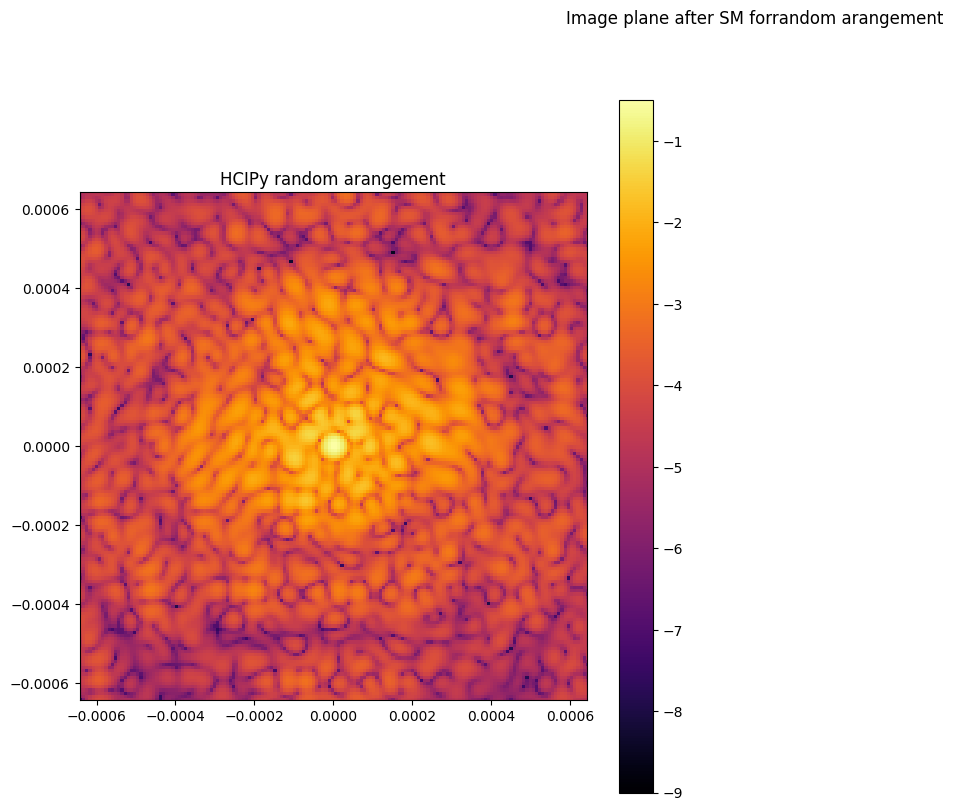

In [42]:
### Propagate to image plane
## HCIPy
# Propagate from pupil plane through SM to image plane
im_pistoned_hc = prop(hsm(wf)).intensity

### Display intensity of both cases image plane
plt.figure(figsize=(18, 9))
plt.suptitle('Image plane after SM forrandom arangement')

plt.subplot(1, 2, 1)
hcipy.imshow_field(np.log10(im_pistoned_hc / norm_hc), cmap='inferno', vmin=-9)
plt.title('HCIPy random arangement')
plt.colorbar()